### Spatial Convergence. Here we do the spatial convergence. 

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

float64


Specify initial setup by loading parameters required for the traveling wave.

In [2]:
signal_params = ConfigDict(KDV_params_traveling)
print(signal_params)

Advection_basis_name: constant
E: 30
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 0.0001
equation_name: KdV
initial_condition: traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 1.0
nt: 10000
nx: 64
tmax: 1.0
xmax: 3.141592653589793
xmin: -3.141592653589793



Next, we specify a signal, by specifying a solver. We specifically require a very small timestep as to eliminate the dominant temporal errors, and test the spatial convergence.  

In [3]:
signal_params.update(E=1,method='Dealiased_SETDRK4',nt = int(1e3),dt=1e-13,tmax= 1e-10,nx = 4*32,P=1,S=0,noise_magnitude=10)

Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [4]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)

In [5]:
key1 = jax.random.PRNGKey(0)
dW = jax.random.normal(key1, shape=(signal_model.params.nt, signal_model.params.E, signal_model.params.P))
#dW = -0.1*jnp.ones_like(dW)
dW = dW
key = jax.random.PRNGKey(1)
final, all = signal_model.run(initial_signal, signal_model.params.nt, dW,key)
print(final.shape,all.shape)

(1, 128) (1000, 1, 128)


In [6]:
print(type(all))
print(len(all))
print(all[0].shape) # particles
print(all[1].shape) # signal
#out shape is (n_total, n_particles, n_dim)

<class 'jaxlib.xla_extension.ArrayImpl'>
1000
(1, 128)
(1, 128)


We now generate the path used $W(t_{n}) = \sum_{i=1}^{n} \Delta W_i = \sum_{i=1}^{n}[W(t_i)-W(t_{i-1})]$, where $W(t_0)=0$.

In [7]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)
W = jnp.cumsum(dW, axis=0)
W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
print(W.shape)
W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
W_new = W_new.at[1:,:,:].set(W)

E = signal_model.params.E
nt = signal_model.params.nt
nx = signal_model.params.nx
x = signal_model.x
xmax = signal_model.params.xmax
xmin = signal_model.params.xmin
dt = signal_model.params.dt

analytic = jnp.zeros([nt+1, E, nx])
#analytic = analytic.at[0,:,:].set(initial_signal)
beta = 3.0
initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))
for n in range(signal_model.params.nt+1):
    ans = initial_condition_jitted((x - 4*beta**2 * (dt*n) - 1/2*W_new[n,:,:] + xmax)%(xmax*2) - xmax, E, signal_params.initial_condition)
    analytic = analytic.at[n,:,:].set(ans)

# takes a min at higher resolution.


(1, 128)
(1000, 1, 128)
(1001, 1, 128)
(1000, 1, 1)


In [8]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,:,:].T, color='k',linewidth=0.2,label='signal')
    plt.plot(signal_model.x, analytic[da_step,:,:].T, color='r',linewidth=0.2,label='analytic')
    plt.legend()
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.params.nt))


(1001, 1, 128) (1001, 1, 128)


interactive(children=(IntSlider(value=500, description='da_step', max=1000), Output()), _dom_classes=('widget-…

<function __main__.plot(da_step)>

In [9]:
def plot(da_step):
    plt.title('Difference between signal and analytic')
    plt.plot(signal_model.x, signal[da_step,:,:].T-analytic[da_step,:,:].T, color='k',linewidth=2)
    plt.legend(['signal'])
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.params.nt))

(1001, 1, 128) (1001, 1, 128)


interactive(children=(IntSlider(value=500, description='da_step', max=1000), Output()), _dom_classes=('widget-…

<function __main__.plot(da_step)>

In [10]:
def relative_error(signal, analytic):
    return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)

print(relative_error(signal[:,:,:], analytic[:,:,:]))#space time relative error.

8.50405350095984e-05


I manually record the relative L2 errors at different resolutions. 

In [11]:
a1 = 1.3359985504458728e-05

a2 = 1.4917710093357412e-07

a3 = 9.510210529746436e-12

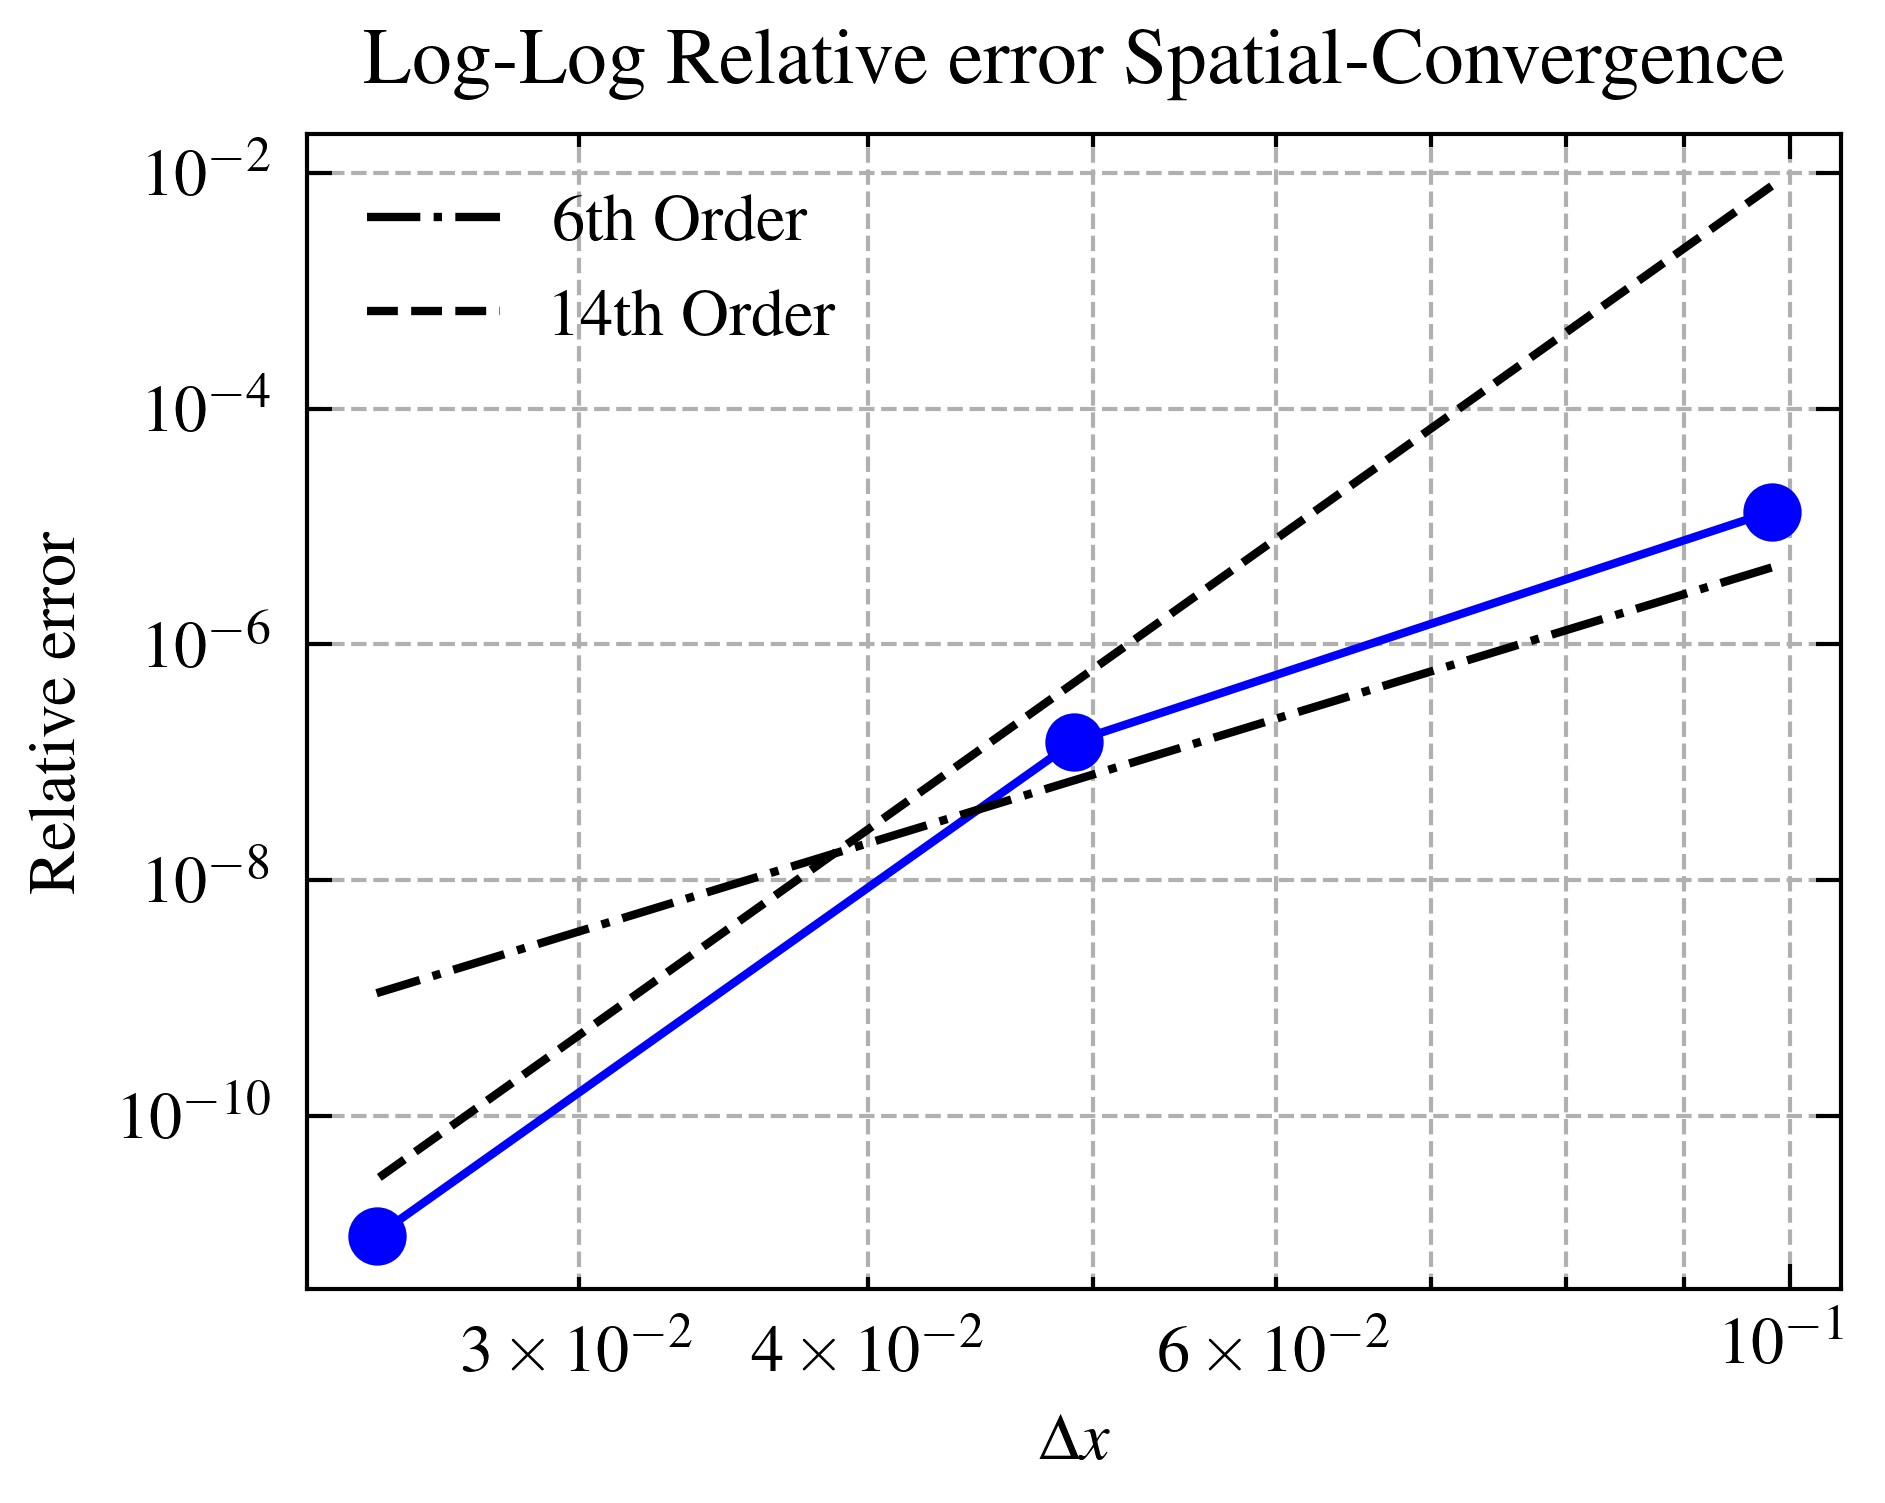

In [12]:
import numpy as np
# Create a list of the two numbers
dx_scale = (xmax - xmin)/64
dx = dx_scale*np.asarray([1.,1/2,1/4])
values = np.asarray([a1, a2, a3])

dt = dx
# Create a log-log plot
plt.figure()
plt.loglog(dt, values, marker='o', linestyle='-', color='b')

plt.loglog(dt,dt**6*5, linestyle='-.', color='k', label='6th Order')
plt.loglog(dt,dt**14*1e12, linestyle='--', color='k', label='14th Order')

plt.xlabel(r'$\Delta x$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error Spatial-Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/convergence_space.png',bbox_inches='tight',dpi=300)
plt.show()


In [13]:
import numpy as np
from jax import vmap

# Define the resolutions to test
nx_list = np.array([4,8, 16, 32 ,64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768], dtype=int)
errors = []
for nx_val in nx_list:
    # You cannot "undo" an instantiation of a class in Python.
    # If you want to re-instantiate with new parameters, just create a new instance.
    # If you want to clear a previous instance, you can optionally delete it:
    
    signal_params = ConfigDict(KDV_params_traveling)
    signal_params.update(E=1,method='Dealiased_SETDRK4',nt = int(1e3),dt=1e-13,tmax= 1e-10,nx = int(nx_val),P=1,S=0,noise_magnitude=0,initial_condition='ultra_steep_traveling_wave')
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)

    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    

    dW = jax.random.normal(key, shape=(signal_model.params.nt, signal_model.params.E, signal_model.params.P))

    print(signal_model.params.nt,dW.shape)
    final, all = signal_model.run(initial_signal, signal_model.params.nt, dW, key)

    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)

    W = jnp.cumsum(dW, axis=0)
    W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
    W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
    W_new = W_new.at[1:,:,:].set(W)

    E = signal_model.params.E
    nt = signal_model.params.nt
    nx = signal_model.params.nx
    x = signal_model.x
    xmax = signal_model.params.xmax
    xmin = signal_model.params.xmin
    dt = signal_model.params.dt
    
    analytic = jnp.zeros([nt+1, E, nx])

    initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
    def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
        return initial_condition_jitted((x - 15*15 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)
    compute_ans_vmap = vmap(compute_ans, in_axes=(0, None, None, None, None, None, None))

    n_values = jnp.arange(signal_model.params.nt + 1)
    analytic = compute_ans_vmap(n_values, x, dt, W_new, xmax, E, signal_params.initial_condition)
    print("signal_shape, analytic_shape",signal.shape,analytic.shape)
    errors.append( relative_error(signal, analytic))
    del signal_model
    # takes a min at higher resolution.

1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 4) (1001, 1, 4)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 8) (1001, 1, 8)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 16) (1001, 1, 16)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 32) (1001, 1, 32)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 64) (1001, 1, 64)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 128) (1001, 1, 128)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 256) (1001, 1, 256)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 512) (1001, 1, 512)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 1024) (1001, 1, 1024)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 2048) (1001, 1, 2048)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 4096) (1001, 1, 4096)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 8192) (1001, 1, 8192)
1000 (1000, 1, 1)
signal_shape, analytic_shape (1001, 1, 16384) (1001, 1, 16384)
1

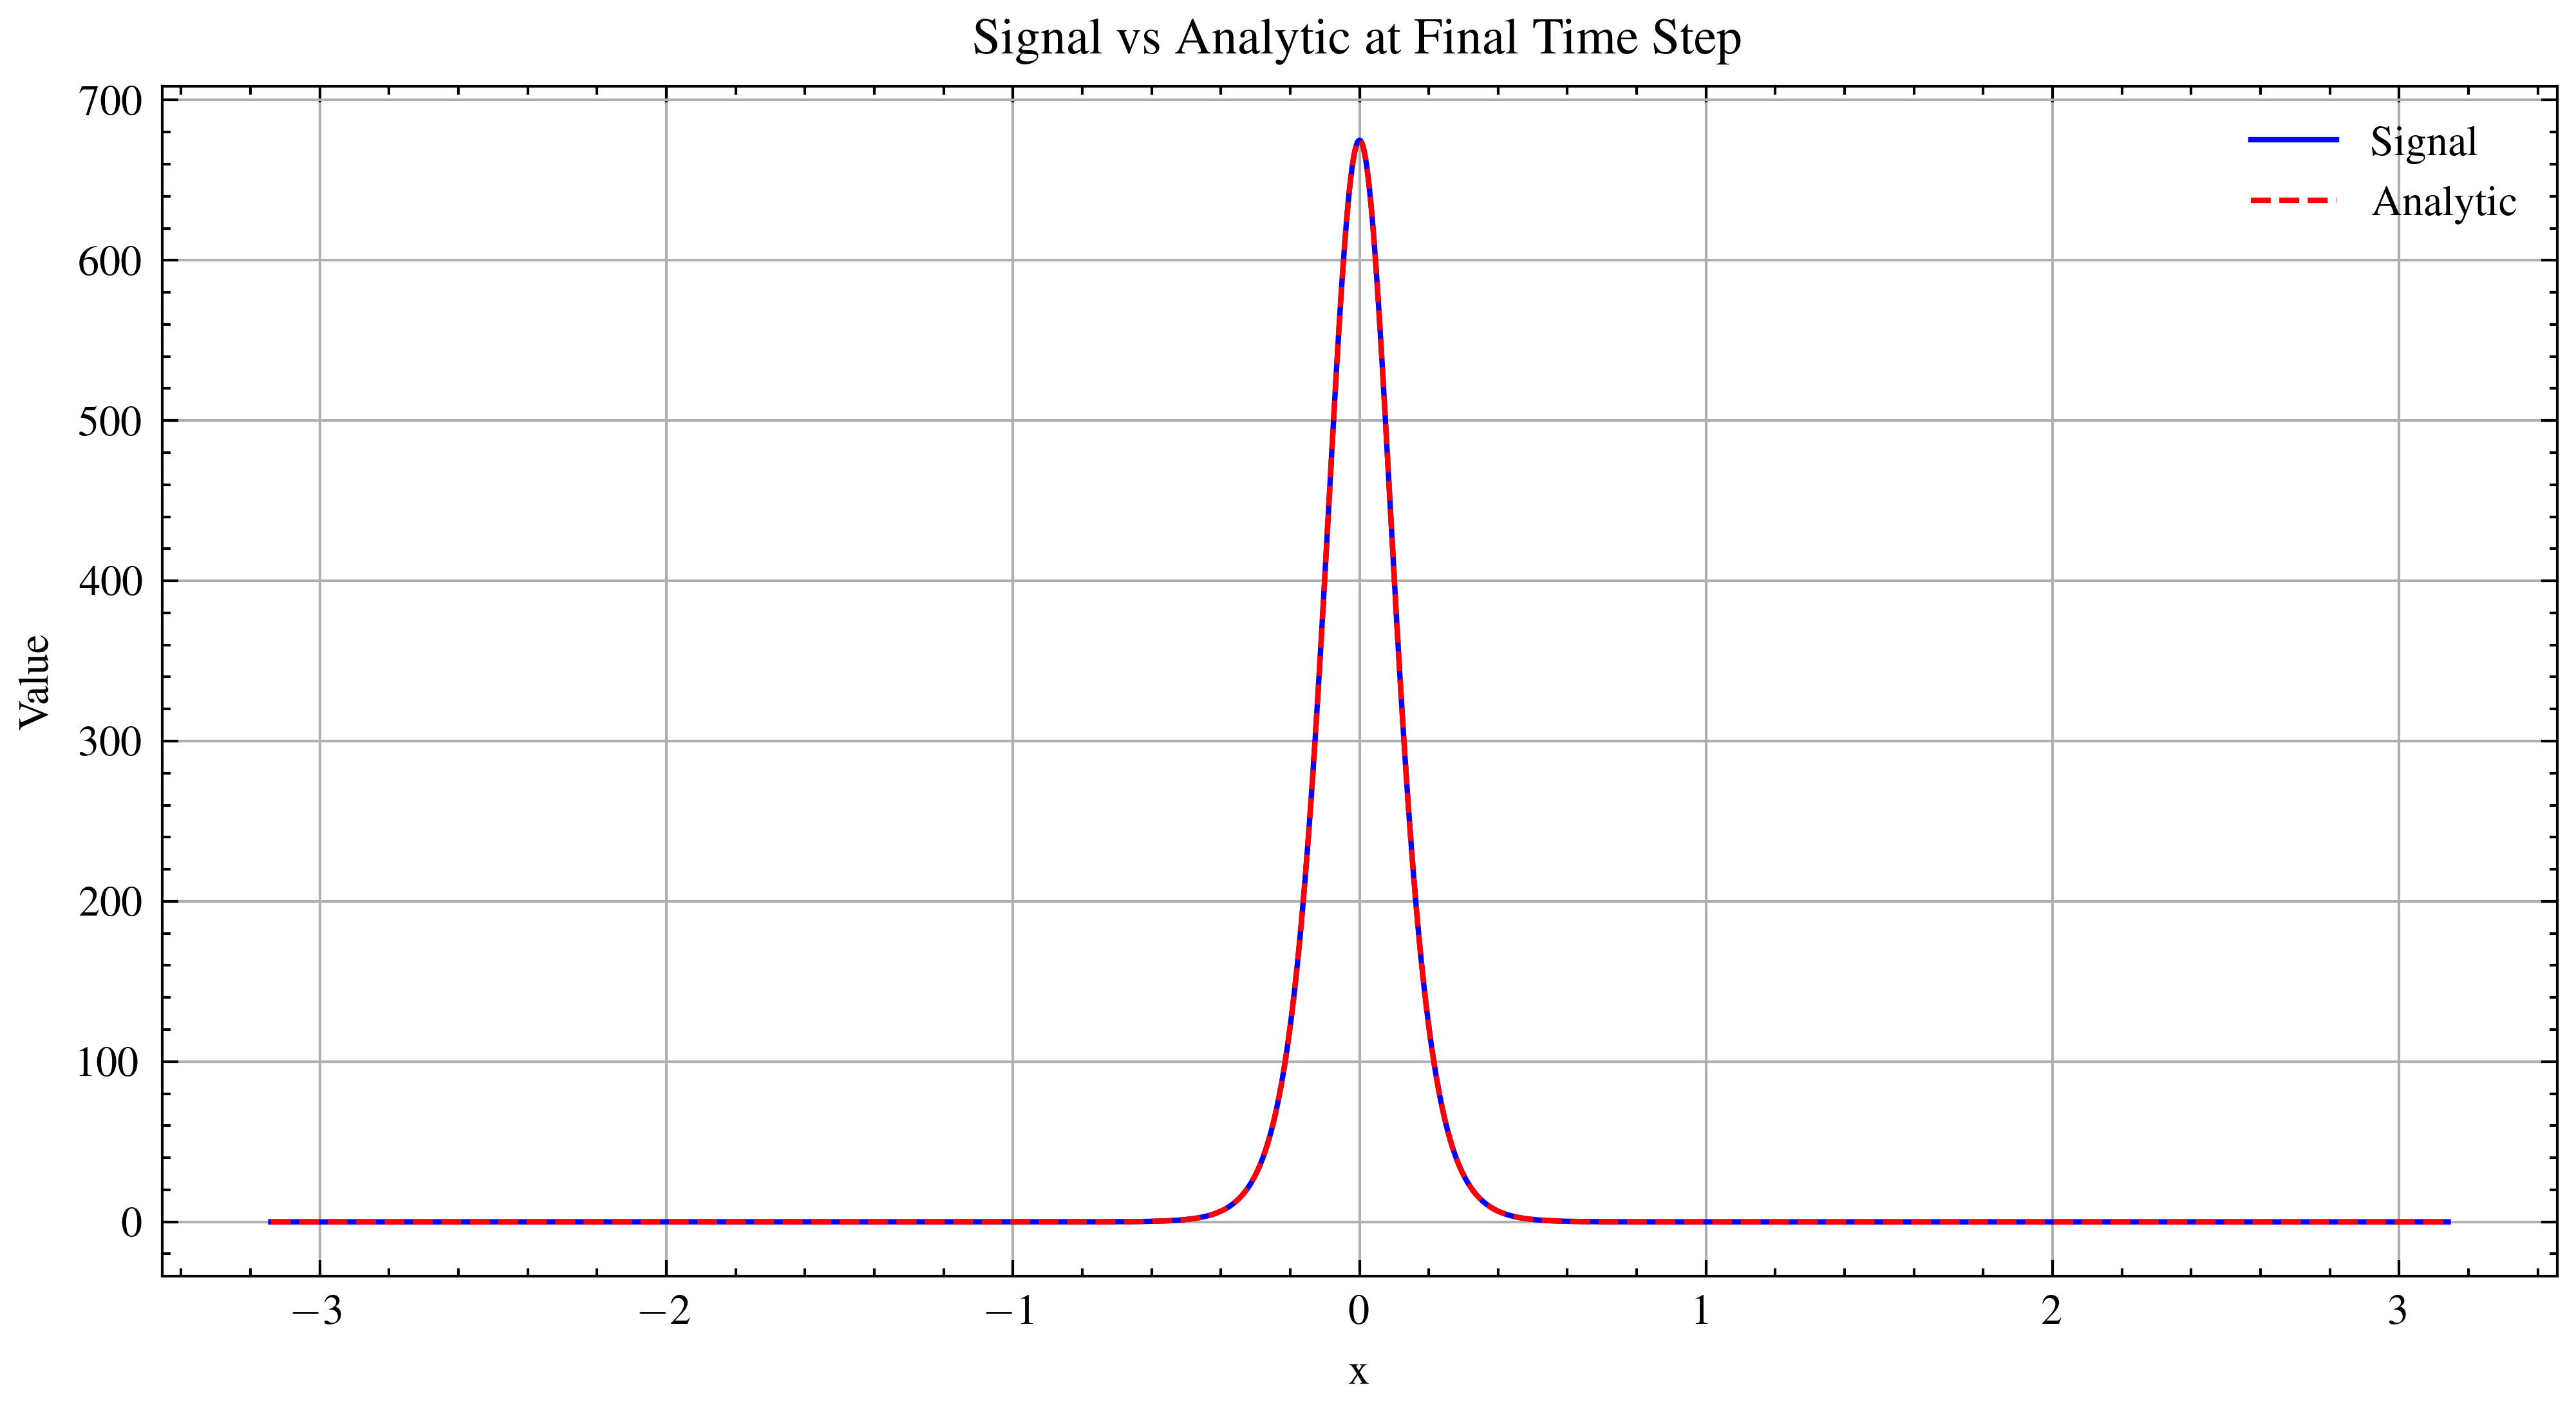

interactive(children=(IntSlider(value=1000, description='Step', max=1000), Output()), _dom_classes=('widget-in…

ValueError: cannot find widget or abbreviation for argument: 'i'

In [14]:
import ipywidgets as widgets

plt.figure(figsize=(8, 4))
plt.plot(x, signal[-1, 0, :], label='Signal', color='b')
plt.plot(x, analytic[-1, 0, :], label='Analytic', color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Signal vs Analytic at Final Time Step')
plt.legend()
plt.grid(True)
plt.show()


@widgets.interact(i=widgets.IntSlider(min=0, max=signal.shape[0]-1, step=1, value=signal.shape[0]-1, description='Step'))
def plot_difference(i):
    plt.figure(figsize=(8, 4))
    plt.plot(x, signal[i, 0, :] - analytic[i, 0, :], color='k', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('Difference')
    plt.title(f'Difference: Signal - Analytic at Step {i}')
    plt.grid(True)
    plt.show()

interact(plot_difference)

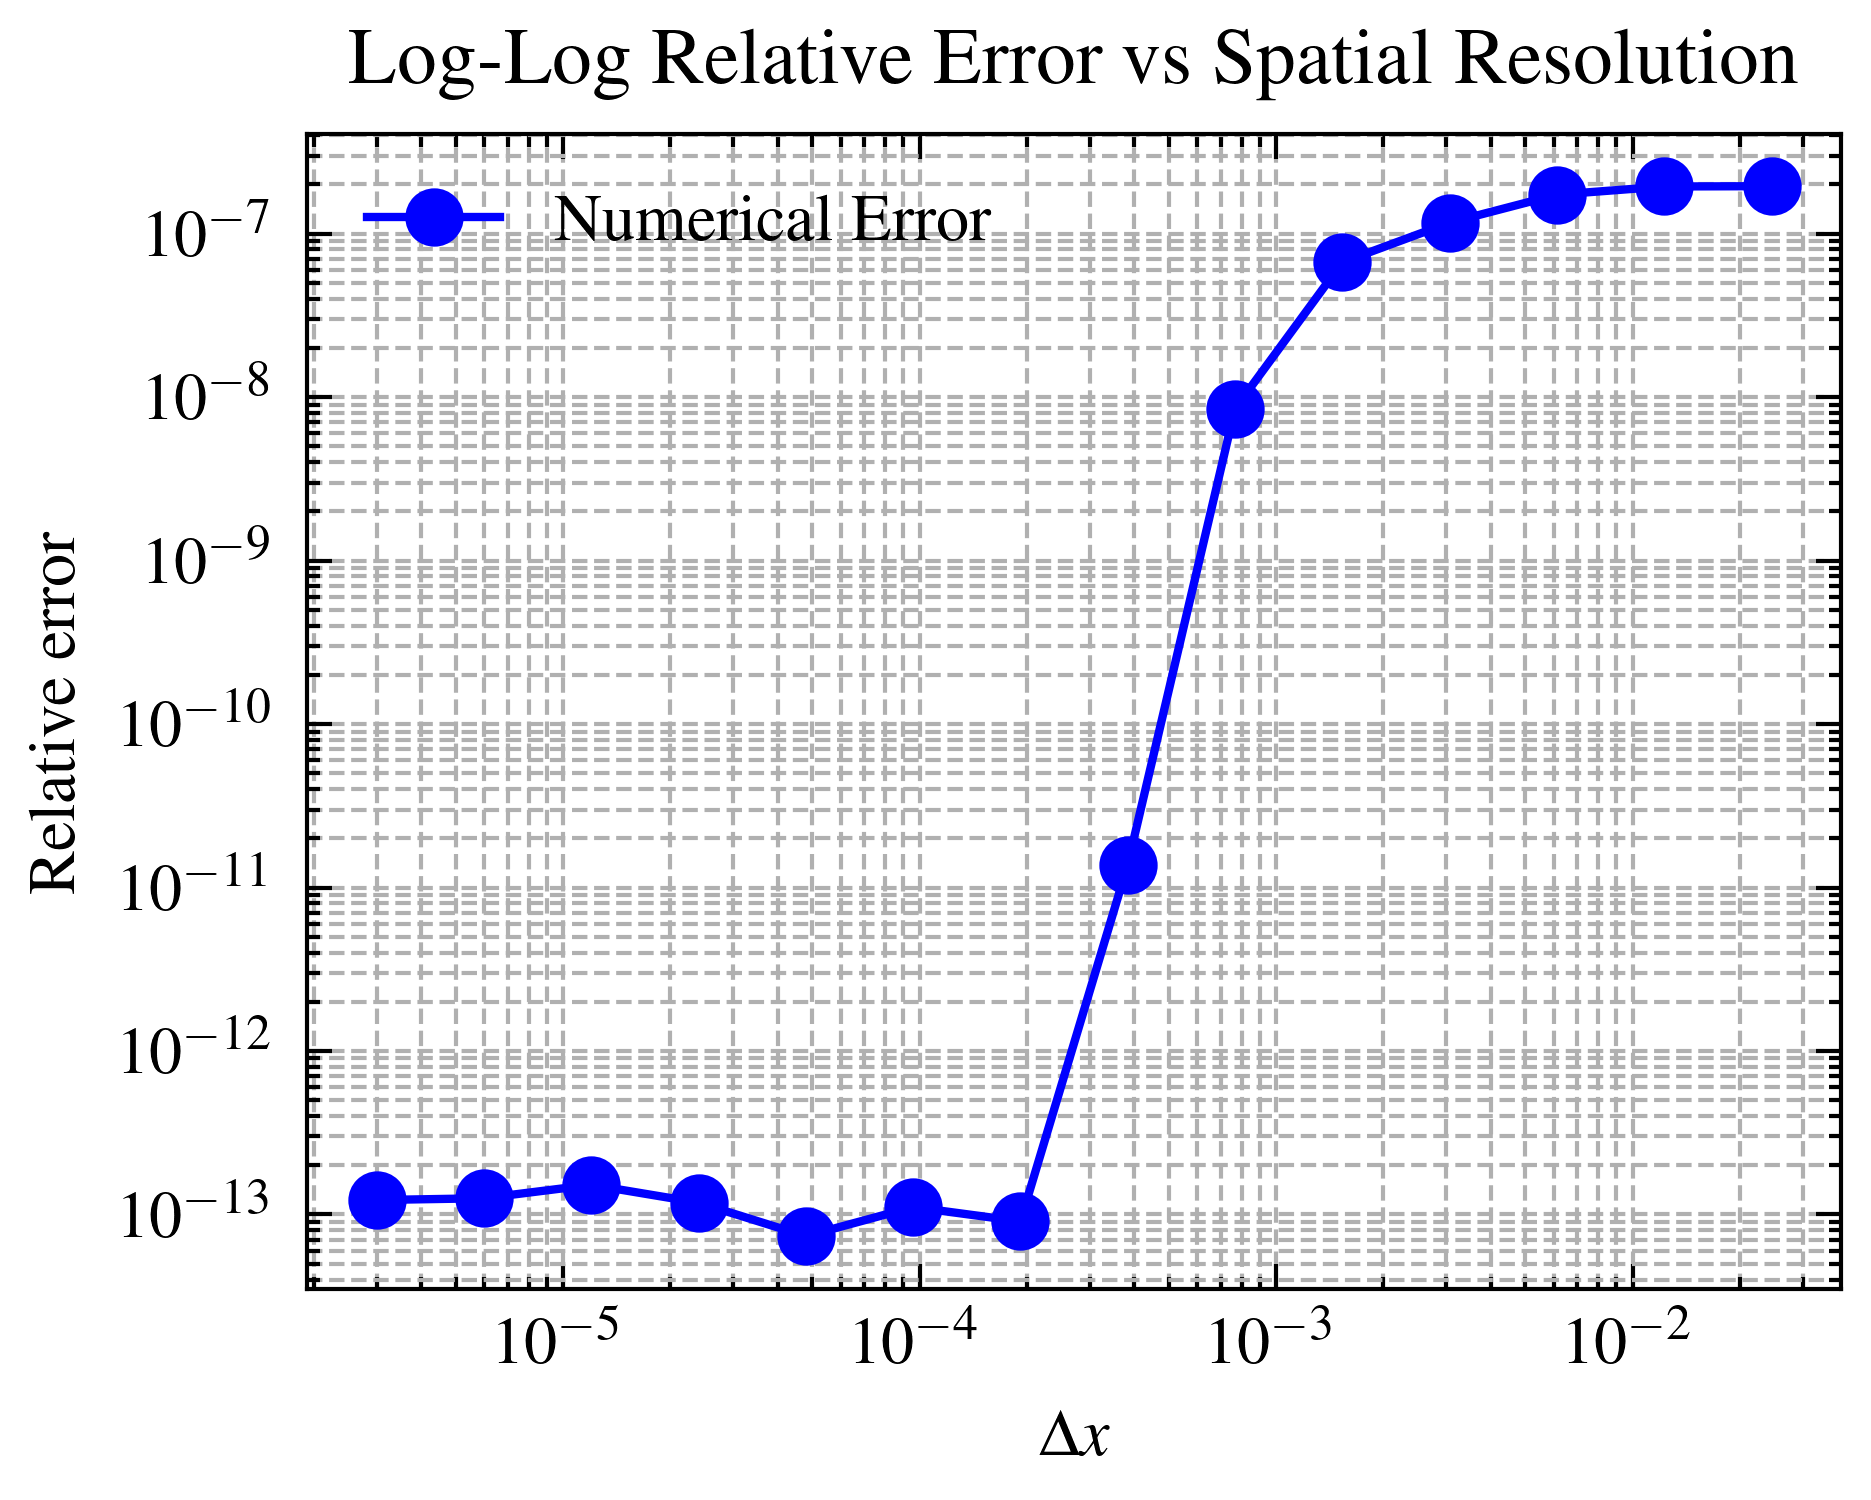

In [15]:
import numpy as np
# config.update("jax_enable_x64", True)

# Prepare data for log-log plot
dx_plot = dx_scale / nx_list
errors_np = np.array([float(e) for e in errors])

plt.figure()
plt.loglog(dx_plot, errors_np, marker='o', linestyle='-', color='b', label='Numerical Error')
plt.xlabel(r'$\Delta x$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative Error vs Spatial Resolution')
plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/convergence_space.png',bbox_inches='tight',dpi=300)
plt.legend()
plt.show()


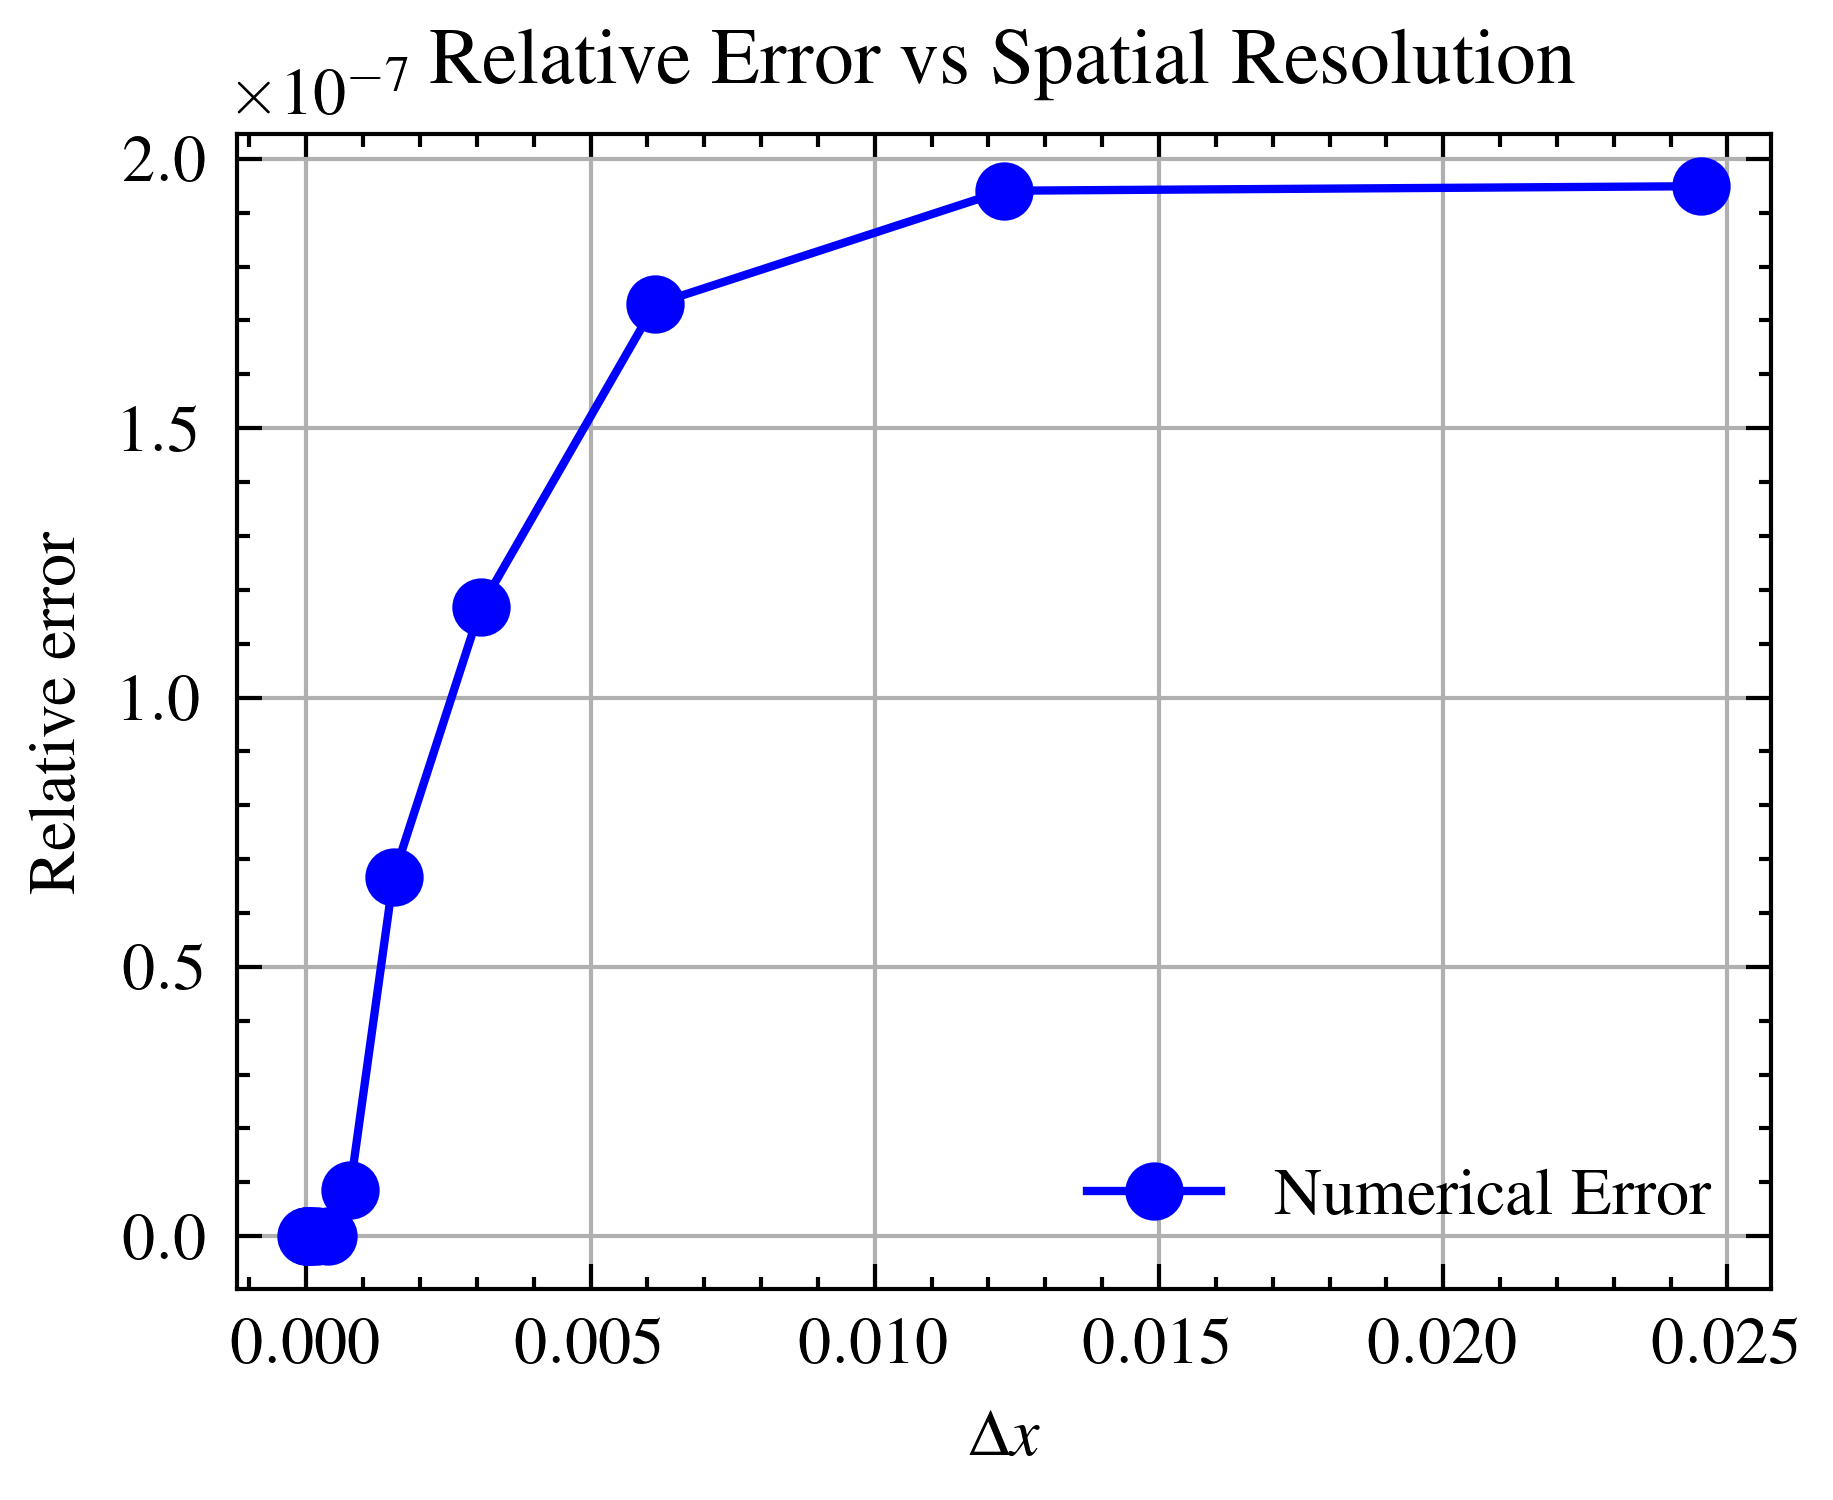

In [16]:
plt.figure()
plt.plot(dx_plot, errors_np, marker='o', linestyle='-', color='b', label='Numerical Error')
plt.xlabel(r'$\Delta x$')
plt.ylabel('Relative error')
plt.title('Relative Error vs Spatial Resolution')
plt.grid(True)
plt.legend()
plt.show()